## 뷰메진 Assignment Test
### 컴퓨터비전 엔지니어 지원자: 정대현

**핵심 요소**
1. Segmentation backbone network에 대한 이해
2. Pipeline 구축
   data loader → train/validation → test(+evaluation)
3. 문제 해결 능력
4. GitHub을 이용한 코드 관리

**추가 요소**
1. 코딩 스타일
    1. Class
    2. Module
2. 창의적 아이디어
    1. crack segmentation : 오픈 소스 분할 모델 수정하여 crack 검출 성능을 높이기 위한 아이디어
    2. crack measurement : crack 길이와 폭을 측정하는 방법에 대한 아이디어
    3. augmentation : 학습 성능을 높이기 위해 다양한 아이디어

### 0. 라이브러리 호출 & 데이터 경로 지정하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random, tqdm
import os, cv2
import math
from glob import glob
#import gc
#gc.enable()
import warnings
warnings.filterwarnings("ignore")
import albumentations as album

#imshow을 사용할때 커널이 죽을 경우 사용
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

segmentation_models_pytorch documents  
https://smp.readthedocs.io/en/latest/index.html

In [2]:
DATA_DIR = './mini_crack_segmentation_dataset/'

x_train_dir = os.path.join(DATA_DIR, 'train/input')
y_train_dir = os.path.join(DATA_DIR, 'train/output')

x_valid_dir = os.path.join(DATA_DIR, 'val/input')
y_valid_dir = os.path.join(DATA_DIR, 'val/output')

x_test_dir = os.path.join(DATA_DIR, 'test/input')
y_test_dir = os.path.join(DATA_DIR, 'test/output')

In [4]:
#배경은 검은색, 크랙은 흰색 (RGB기준)
class_names = ['background', 'crack']
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'crack']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### 1. 시각화 함수 설정

In [6]:
def visualize(**images):
    #이미지는 한줄에 표시
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

### 2. 크랙 데이터셋 정의

In [11]:
class crackDataset(torch.utils.data.Dataset):
    """
    이미지 읽기, 확대 적용 및 변환 전처리
    Args:
        images_dir (str): 이미지 폴더 경로
        masks_dir (str): 분할 마스크 폴더 경로
        class_rgb_values (list): 분할 마스크 확대(확대)에서 추출할 선택한 클래스의 RGB 값
        (albumentations.Compose): data transfromation pipeline(e.g. 반전, 스케일 처리 등)
        preprocessing (albumentations.Compose): data preprocessing(e.g. 정규화, 형상 조작, etc.)
    
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        #경로는 여기서 한번에 불러오기
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # 이미지와 마스크 읽어오기
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # 변환 적용
        if self.augmentation:
        
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #전처리 적용
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        #이미지와 마스크 반환

    def __len__(self):
        # 길이 반환
        return len(self.image_paths)

해당 커스텀 데이터 셋을 통해서 이미지 확인

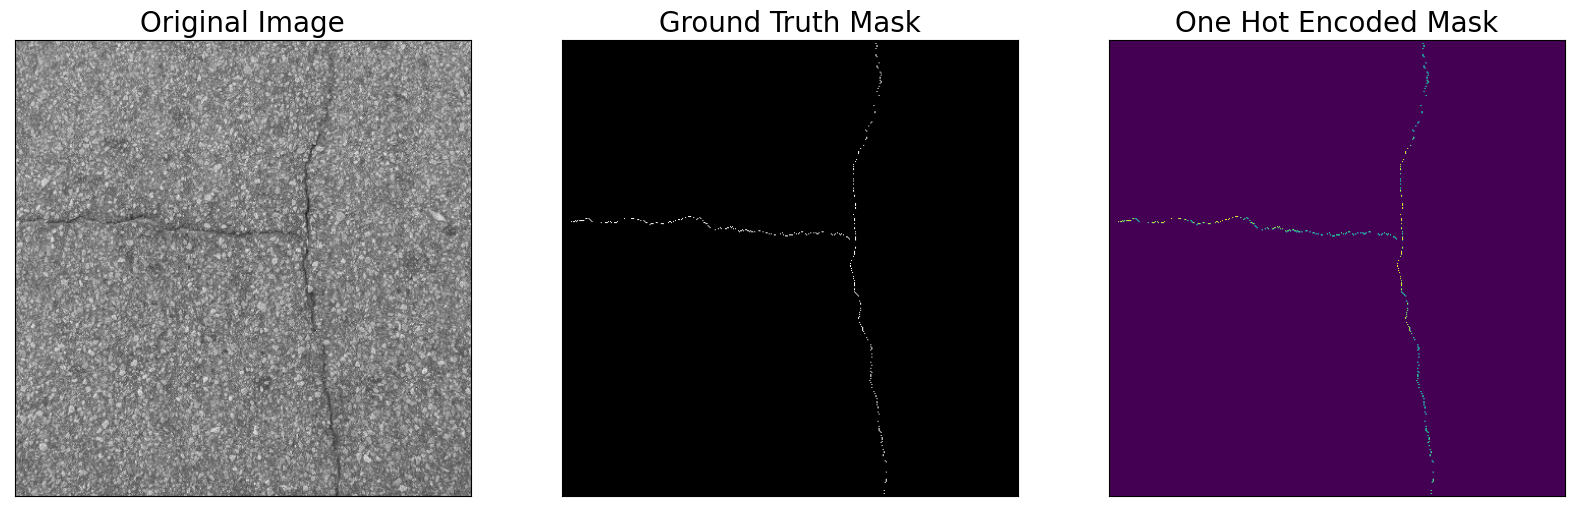

In [16]:
dataset = crackDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

**[Question]**

1) 제안한 모델(들)을 사용한 이유와 근거를 간략히 적어주세요.


2) 성능을 향상시키기 위해 노력했다면, 그 내용과 근거를 간략히 적어주세요.


3) 결과에 대한 본인의 해석을 간략히 적어주세요.


4) 만약 시간이 더 주어진다면 가장 시도해보고 싶은 것을 하나 제시하고 그 이유에 대해서 간략히 적어주세요.
